In [1]:
import pandas as pd
import numpy as np
import scipy.stats
from sklearn import metrics

trialOrders = {}

import os

path = './events'

def compute_skourascore(subject_performace, idealized_performance):
    return scipy.stats.pearsonr(subject_performace, idealized_performance)[0]

def compute_auc_score(counterbalanced_angles, length):
    print(np.full((length, 1), 90))
    score = metrics.auc(np.arange(length * 1.0), counterbalanced_angles) / metrics.auc(np.arange(length * 1.0), np.full((length, 1), 90))
    return score

def compute_peak_score(counterbalanced_angles):
    return np.amax(counterbalanced_angles)

def compute_ttp_score(counterbalanced_angles):
    return np.argmax(counterbalanced_angles)

def find_empty_times(data):
    intermissions = data[data['instruction']==" Push Button"].index.tolist()
    rests = data[data['instruction']==" Rest"]
    first_scan_index = data[data['instruction']!=" Rest"].index.tolist()[0] - 1
    first_rest_at_end = data[data['instruction']!=" Rest"].index.tolist()[-1] + 1
    times = [first_scan_index] + intermissions + [first_rest_at_end]
    return times

def determine_trialorder(data, times):
    trialOrder = []
    for trialnum in range(12):
        this_trial = data[(times[trialnum] + 1):times[trialnum + 1]][data['feedback']=="On"]
        trialOrder += [this_trial['left_text'].tolist()[0][1:] + "-" + this_trial['right_text'].tolist()[0][1:], this_trial['instruction'].tolist()[0][1:]]
    return trialOrder

files = []
# r=root, d=directories, f = files
for r, d, f in os.walk(path):
    for file in f:
        if '.tsv' in file:
            files.append(os.path.join(r, file))
            

In [2]:
import copy
means_template = {'ID':[], 'down': [], 'up': [], 'both': []}

series_template = {'ID':[]}
for i in range(1, 13):
    series_template[str(i)] = []

downseries_template = {'ID':[]}
for i in range(1, 7):
    downseries_template[str(i)] = []
    
upseries_template = {'ID':[]}
for i in range(1, 7):
    upseries_template[str(i)] = []

skouradict = {'means':copy.deepcopy(means_template), 'series':copy.deepcopy(series_template), 'downseries':copy.deepcopy(downseries_template), 'upseries': copy.deepcopy(upseries_template)}
aucdict = {'means':copy.deepcopy(means_template), 'series':copy.deepcopy(series_template), 'downseries':copy.deepcopy(downseries_template), 'upseries': copy.deepcopy(upseries_template)}
peakdict = {'means':copy.deepcopy(means_template), 'series':copy.deepcopy(series_template), 'downseries':copy.deepcopy(downseries_template), 'upseries': copy.deepcopy(upseries_template)}
ttpdict = {'means':copy.deepcopy(means_template), 'series':copy.deepcopy(series_template), 'downseries':copy.deepcopy(downseries_template), 'upseries': copy.deepcopy(upseries_template)}

for i in range(len(files)):
    #parsing filename to find NKI subject ID
    subpos = files[i].find('sub-A')
    subjID = files[i][(subpos + 4):(subpos + 13)]
    #print(subjID)
    #reading events.tsv file as "data"
    data = pd.read_csv(files[i], sep="\t")
    times = find_empty_times(data)
    trialOrder = determine_trialorder(data, times)
    if trialOrder[1] == 'Focus':
        continue
    
    skouradict['series']['ID'] += [subjID]
    skouradict['upseries']['ID'] += [subjID]
    skouradict['downseries']['ID'] += [subjID]
    
    aucdict['series']['ID'] += [subjID]
    aucdict['upseries']['ID'] += [subjID]
    aucdict['downseries']['ID'] += [subjID]
    
    peakdict['series']['ID'] += [subjID]
    peakdict['upseries']['ID'] += [subjID]
    peakdict['downseries']['ID'] += [subjID]
    
    ttpdict['series']['ID'] += [subjID]
    ttpdict['upseries']['ID'] += [subjID]
    ttpdict['downseries']['ID'] += [subjID]
    
    series_position = 1
    downseries_position = 1
    upseries_position = 1
    
    for trialnum in range(12):
        #this_trial is the data just from the trial of trialnum
        this_trial = data[(times[trialnum] + 1):times[trialnum + 1]]
        length = len(this_trial.needle_position.values)
        instruction = trialOrder[(trialnum * 2) + 1]
        polarity = trialOrder[(trialnum * 2)]
        if instruction == "Focus":
            if polarity == 'Focused-Wandering':
                idealized = np.linspace(90, 90 + (length - 1), num=length)
                auc_balanced = (this_trial.needle_position.values - 90)
            elif polarity == 'Wandering-Focused':
                idealized = np.linspace(90, 90 - (length - 1), num=length)
                auc_balanced = (this_trial.needle_position.values - 90) * -1
            
            #calculating scores
            auc = compute_auc_score(auc_balanced, length)
            skourascore = compute_skourascore(this_trial.needle_position.values, idealized)
            peak = compute_peak_score(auc_balanced)
            ttp = compute_ttp_score(auc_balanced)
            
            #storing scores in memory
            skouradict['downseries'][str(downseries_position)] += [skourascore]
            aucdict['downseries'][str(downseries_position)] += [auc]
            peakdict['downseries'][str(downseries_position)] += [peak]
            ttpdict['downseries'][str(downseries_position)] += [ttp]
            
            downseries_position += 1
        elif instruction == "Wander":
            if polarity == 'Focused-Wandering':
                idealized = np.linspace(90, 90 - (length - 1), num=length)
                auc_balanced = (this_trial.needle_position.values - 90) * -1
            elif polarity == 'Wandering-Focused':
                idealized = np.linspace(90, 90 + (length - 1), num=length)
                auc_balanced = (this_trial.needle_position.values - 90)
            
            #calculating scores
            auc = compute_auc_score(auc_balanced, length)
            skourascore = compute_skourascore(this_trial.needle_position.values, idealized)
            peak = compute_peak_score(auc_balanced)
            ttp = compute_ttp_score(auc_balanced)
            
            #storing scores in memory
            skouradict['upseries'][str(upseries_position)] += [skourascore]
            aucdict['upseries'][str(upseries_position)] += [auc]
            peakdict['upseries'][str(upseries_position)] += [peak]
            ttpdict['upseries'][str(upseries_position)] += [ttp]
            
            upseries_position += 1
        else:
            print("something is horribly wrong")
        skouradict['series'][str(series_position)] += [skourascore]
        aucdict['series'][str(series_position)] += [auc]
        peakdict['series'][str(series_position)] += [peak]
        ttpdict['series'][str(series_position)] += [ttp]
        
        series_position += 1

/home/rouse/.local/lib/python3.6/site-packages/ipykernel_launcher.py:37: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


[[90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]]
[[90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]]
[[90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]]
[[90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]]
[[90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]]
[[90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]

 [90]]
[[90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]]
[[90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]]
[[90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]]
[[90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]]
[[90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]]
[[90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90

 [90]]
[[90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]]
[[90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]]
[[90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]]
[[90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]]
[[90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]]
[[90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90

 [90]]
[[90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]]
[[90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]]
[[90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]]
[[90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]]
[[90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]]
[[90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90

[[90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]]
[[90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]]
[[90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]]
[[90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]]
[[90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]]
[[90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]

[[90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]]
[[90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]]
[[90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]]
[[90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]]
[[90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]]
[[90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]

 [90]]
[[90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]]
[[90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]]
[[90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]]
[[90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]]
[[90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]

[[90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]]
[[90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]]
[[90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]]
[[90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]]
[[90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]]
[[90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]

[[90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]]
[[90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]]
[[90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]]
[[90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]]
[[90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]]
[[90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]

 [90]]
[[90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]]
[[90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]]
[[90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]]
[[90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]]
[[90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]

[[90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]]
[[90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]]
[[90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]]
[[90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]]
[[90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]]
[[90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]

 [90]]
[[90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]]
[[90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]]
[[90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]]
[[90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]]
[[90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]]
[[90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90

[[90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]]
[[90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]]
[[90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]]
[[90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]]
[[90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]]
[[90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]

 [90]]
[[90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]]
[[90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]]
[[90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]]
[[90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]]
[[90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]

[[90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]]
[[90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]]
[[90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]]
[[90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]]
[[90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]]
[[90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]
 [90]

In [3]:
#convert series dicts into dataframes
#first skourascores
skouraseries = pd.DataFrame(skouradict['series'])
skouradownseries = pd.DataFrame(skouradict['downseries'])
skouraupseries = pd.DataFrame(skouradict['upseries'])
#now AUC scores
aucseries = pd.DataFrame(aucdict['series'])
aucdownseries = pd.DataFrame(aucdict['downseries'])
aucupseries = pd.DataFrame(aucdict['upseries'])
#now peak scores
ttpseries = pd.DataFrame(ttpdict['series'])
ttpdownseries = pd.DataFrame(ttpdict['downseries'])
ttpupseries = pd.DataFrame(ttpdict['upseries'])
#now TTP scores
peakseries = pd.DataFrame(peakdict['series'])
peakdownseries = pd.DataFrame(peakdict['downseries'])
peakupseries = pd.DataFrame(peakdict['upseries'])

#now sort them by IDs
skouraseries.sort_values(by=['ID'])
skouradownseries.sort_values(by=['ID'])
skouraupseries.sort_values(by=['ID'])
aucseries.sort_values(by=['ID'])
aucdownseries.sort_values(by=['ID'])
aucupseries.sort_values(by=['ID'])
ttpseries.sort_values(by=['ID'])
ttpdownseries.sort_values(by=['ID'])
ttpupseries.sort_values(by=['ID'])
peakseries.sort_values(by=['ID'])
peakdownseries.sort_values(by=['ID'])
peakupseries.sort_values(by=['ID'])

print(skouradownseries)
print(aucdownseries)
print(peakdownseries)
print(ttpdownseries)

           ID         1         2         3         4         5         6
0   A00056556 -0.858515 -0.119566  0.073829 -0.828344 -0.744780  0.643162
1   A00045590  0.893803  0.881107 -0.791549 -0.272037 -0.773506 -0.053749
2   A00060480  0.241091 -0.287431  0.006017  0.437077 -0.920235  0.939580
3   A00055447  0.687423 -0.147973  0.913465  0.734468  0.466453  0.971629
4   A00062248 -0.105693 -0.552806  0.218614  0.857465  0.901624  0.623924
..        ...       ...       ...       ...       ...       ...       ...
72  A00043704 -0.075435 -0.795597  0.876305  0.401227  0.924245  0.884607
73  A00064580 -0.847381  0.938909  0.602037  0.547229 -0.552994  0.973556
74  A00060279 -0.548676 -0.691082 -0.348892 -0.879547 -0.946772 -0.895680
75  A00035827 -0.036788 -0.859439  0.905304  0.716525 -0.386392 -0.620998
76  A00054019  0.775572  0.945220  0.867183 -0.748870  0.271350  0.971052

[77 rows x 7 columns]
           ID         1         2         3         4         5         6
0   A00056556 -

In [4]:
%matplotlib notebook

Create function for plotting learning curves and histograms of arbitrary # of trials

In [5]:
import matplotlib
import matplotlib.pyplot as plt

def learningcurve(seriesdata, length, scoretype):
    x = []
    for i in range(length):
        x += [i + 1]

    series = pd.DataFrame(seriesdata)
    series = series.sort_values(by=['ID'])
    series = series.to_numpy()
    fig, ax = plt.subplots()
    for j in range(len(series)):
        ax.plot(x, series[j][1:], color='b', alpha=0.1)

    # set ticks and tick labels
    ax.set_xlim((1, length))
    ax.set_xticks(x)
    ax.set_xticklabels(x)

    plt.xlabel('Trial Position (not the actual trial number)')
    plt.ylabel('Score')
    plt.title(scoretype + ' learning curves')
    plt.tight_layout()

    plt.show()

    #from IPython.core.display import display, HTML
    #display(HTML("<style>div.output_scroll { height: 55em; }</style>"))
    
def series_histogram(seriesdata, scoretype, length, n_bins):
    series = pd.DataFrame(seriesdata)
    series = series.sort_values(by=['ID'])

    fig, axs = plt.subplots(length, 1, sharey=True, sharex=True)
    for trialPos in range(length):
        axs[trialPos].hist(series[str(trialPos + 1)].to_list(), bins=n_bins)
        axs[trialPos].set_title(scoretype + ' Trial ' + str(trialPos + 1))
    plt.xlabel('Score')
    plt.tight_layout()
    plt.show()

    #from IPython.core.display import display, HTML
    #display(HTML("<style>div.output_scroll { height: 55em; }</style>"))

Skourascore Downregulation-only learning curves

           ID         1         2         3         4         5         6
0   A00056556 -0.032690  0.026331  0.179661 -0.104006 -0.050459  0.304008
1   A00045590  0.138502  0.184739  0.058651  0.507795 -0.138742  0.060899
2   A00060480  0.109794  0.099507  0.224340 -0.135797 -0.620597  0.285954
3   A00055447  0.162605 -0.105209  0.176288 -0.041456  0.208498  0.296497
4   A00062248 -0.109097 -0.103237  0.204324  0.476165  0.247609  0.234869
..        ...       ...       ...       ...       ...       ...       ...
72  A00043704  0.069875 -0.046343  0.757835  0.796969  0.660100  0.115620
73  A00064580 -0.126736  0.268135  0.516615 -0.064692  0.222211  0.494260
74  A00060279 -0.064685 -0.237556  0.101942 -0.676993 -0.271151 -0.034521
75  A00035827 -0.147504 -0.122453  0.360030  0.713820  0.263838 -0.397775
76  A00054019  0.191135  0.079207  0.553085  0.087277 -0.165870  0.323200

[77 rows x 7 columns]


<IPython.core.display.Javascript object>


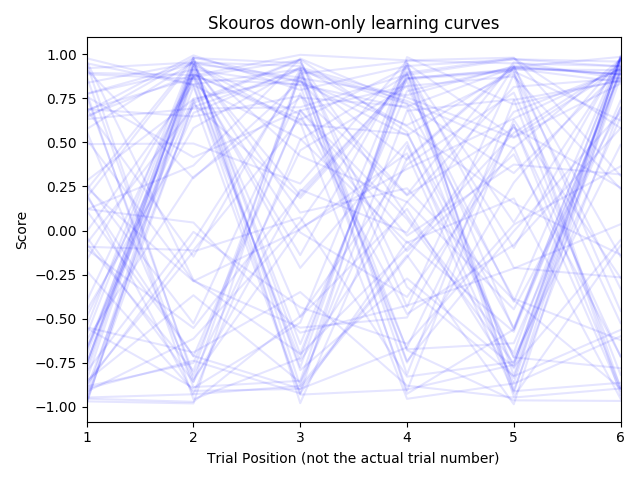

<IPython.core.display.Javascript object>


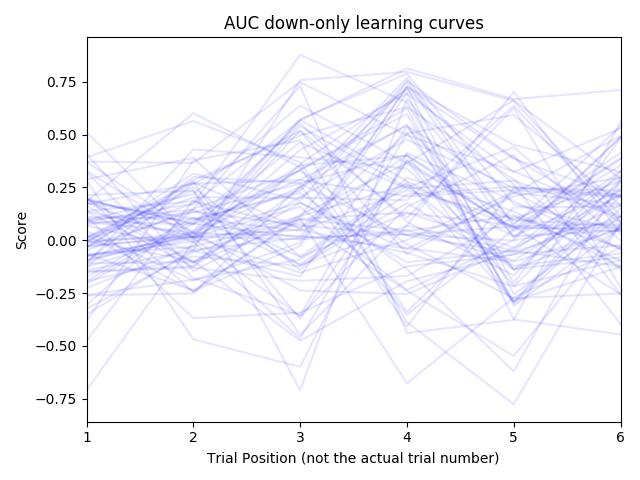

<IPython.core.display.Javascript object>


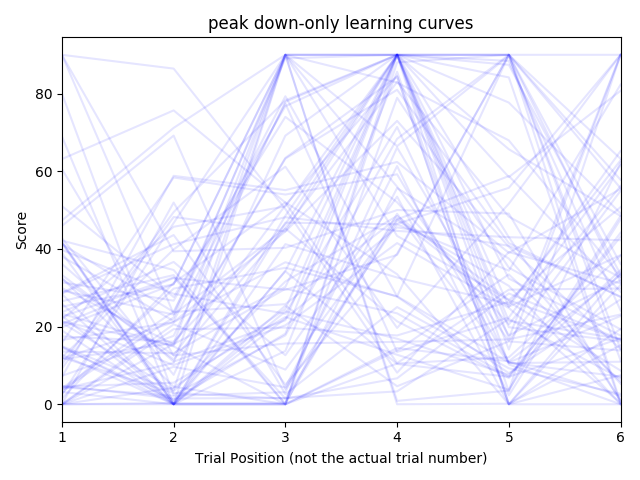

<IPython.core.display.Javascript object>


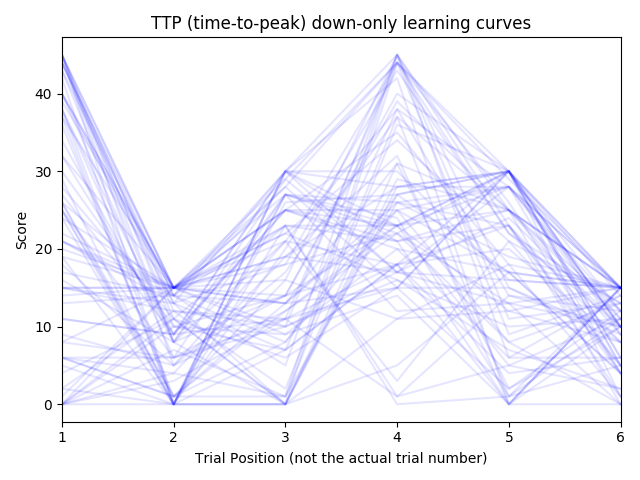

In [6]:
print(aucdownseries)
learningcurve(skouradownseries, 6, "Skouros down-only")
learningcurve(aucdownseries, 6, "AUC down-only")
learningcurve(peakdownseries, 6, "peak down-only")
learningcurve(ttpdownseries, 6, "TTP (time-to-peak) down-only")

from IPython.core.display import display, HTML
display(HTML("<style>div.output_scroll { height: 180em; }</style>"))

Histograms for each trial and score type.

<IPython.core.display.Javascript object>


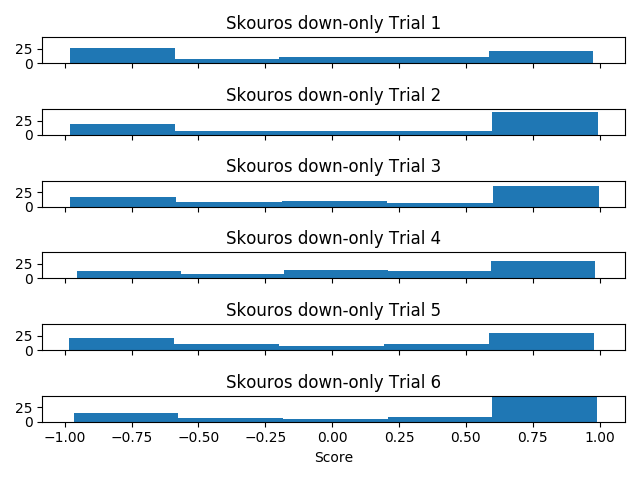

<IPython.core.display.Javascript object>


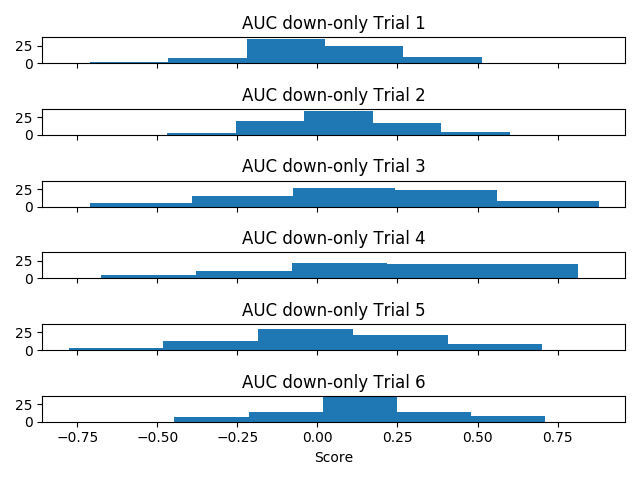

<IPython.core.display.Javascript object>


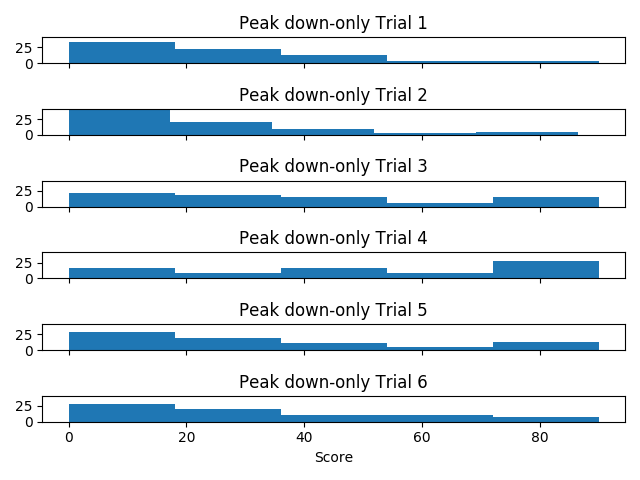

<IPython.core.display.Javascript object>


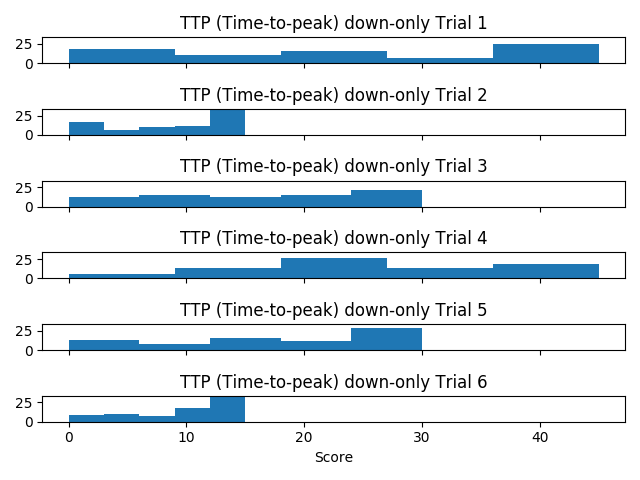

In [7]:
series_histogram(skouradownseries, "Skouros down-only", 6, 5)
series_histogram(aucdownseries, "AUC down-only", 6, 5)
series_histogram(peakdownseries, "Peak down-only", 6, 5)
series_histogram(ttpdownseries, "TTP (Time-to-peak) down-only", 6, 5)